In [3]:
import pandas as pd
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
data = pd.read_csv("Data/new_data.csv")

In [ ]:
data = data.loc[(data['Price'] <= 900) & (data['Price'] >=200)]

In [ ]:
data.shape

In [ ]:
stemmer = stem.PorterStemmer()
stop_words = stopwords.words('english')

def stem_stop(input_text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens_stemmed

In [ ]:
def get_mean_vector(word2vec_model, words):
    words = [word for word in words if word in word2vec_model.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return np.zeroes(300)

In [ ]:
def get_word_vectors(df):
    sentences_train = list(df)
    sentences_train = [stem_stop(i) for i in sentences_train]
    sentences_train = np.array([get_mean_vector(model, i) for i in sentences_train])
    headers = ["Wordvec"+ str(i) for i in range(300)]
#     sentences_train = pd.DataFrame(data=sentences_train, columns=headers)
    return sentences_train

In [ ]:
sentences = get_word_vectors(data['Synopsis'])

In [ ]:
data = data.drop(columns=['Title', 'Edition_year', 'Synopsis'])

In [ ]:
headers = ["Wordvec"+ str(i) for i in range(300)]
sentences = pd.DataFrame(data=sentences , index=data.index, columns=headers)

In [ ]:
sentences.shape

In [ ]:
data = pd.concat([data, sentences], axis=1)

In [ ]:
data.shape

In [ ]:
data.columns

In [10]:
Y = data['Price']

In [11]:
X = data.drop(columns=['Price'])

In [12]:
ce_bin = ce.BinaryEncoder(cols = ['BookCategory', 'Genre','Author','Edition_type'])
X = ce_bin.fit_transform(X, Y)

In [13]:
X = normalize(X)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [187]:
# x = pd.concat((x_train, y_train), axis=1)

In [188]:
# x = x.loc[(x['Price'] >=200) & (x['Price'] <=2000)]

In [189]:
# x_train = x.drop(columns=['Price'])

In [190]:
# y_train = x['Price']

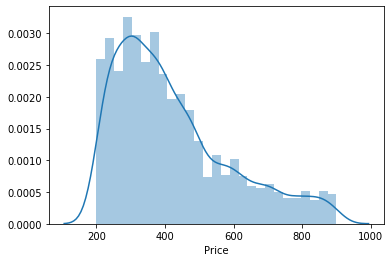

In [15]:
sns.distplot(y_train);
plt.show()

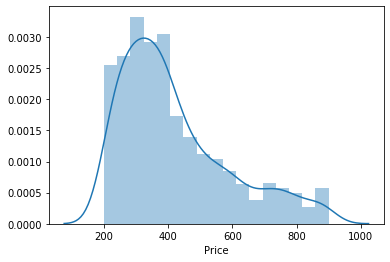

In [16]:
sns.distplot(y_test);
plt.show()

In [17]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3535, 35), (884, 35), (3535,), (884,))

In [217]:
reg_model = DecisionTreeRegressor(max_depth=2)

In [218]:
# reg_model = linear_model.Ridge(alpha=100.0,)

In [219]:
reg_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [220]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

Train error:  0.36909172831060144


In [221]:
predictions = list(reg_model.predict(x_test))

In [222]:
print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Test error:  0.3692984393079537


In [164]:
np.argmax(reg_model.feature_importances_)

2

In [ ]:
# for i, j in zip(y_test[10:50], reg_model.predict(x_test)[10:50]):
#     print(i, j)

In [ ]:
# write predictions to an excel file

# preds = np.array(predictions)
# preds = pd.DataFrame(preds, columns=['Price'])
# preds.to_excel("submission.xlsx", index=None)

In [101]:
train_errors, test_errors, depths = [], [], []

In [102]:
for depth in range(2, 30):
    reg_model = DecisionTreeRegressor(max_depth=depth)
    reg_model.fit(x_train, y_train)
    train_err = np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train)))
    test_err = np.sqrt(mean_squared_log_error(y_test, reg_model.predict(x_test)))
    train_errors.append(train_err)
    test_errors.append(test_err)
    depths.append(depth)

In [103]:
d = pd.DataFrame({"train_error": train_errors, "test_error": test_errors, "depths": depths})

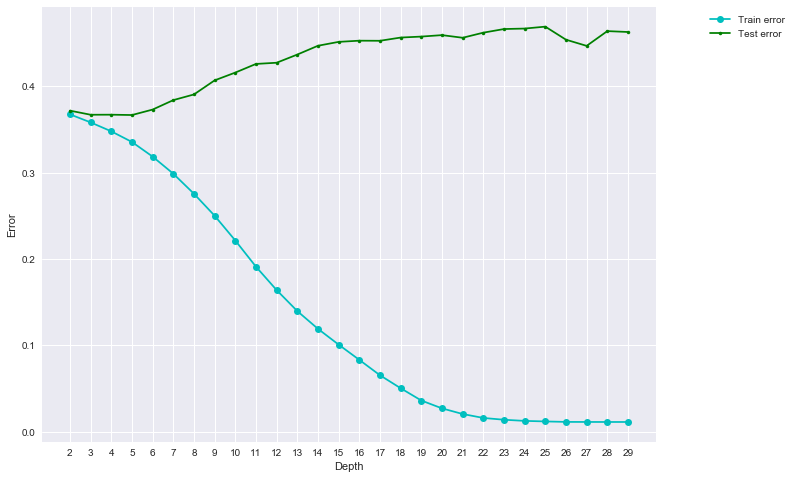

In [106]:
builds = d['depths']
y_stack = np.row_stack((d['train_error'], d['test_error'])) 

fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(builds, y_stack[0,:], label='Train error', color='c', marker='o')
ax1.plot(builds, y_stack[1,:], label='Test error', color='g', marker='.')

plt.xticks(builds)
plt.xlabel('Depth')
plt.ylabel('Error')

handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax1.grid('on')

plt.show()

In [46]:
reg_model = MLPRegressor(verbose=True, max_iter=6000, learning_rate_init=0.001, hidden_layer_sizes=(100, 3))

In [47]:
reg_model.fit(x_train, y_train)

Iteration 1, loss = 103445.09565528
Iteration 2, loss = 103413.26588096
Iteration 3, loss = 103125.54510717
Iteration 4, loss = 102557.21614371
Iteration 5, loss = 101791.11573463
Iteration 6, loss = 100769.44153621
Iteration 7, loss = 99437.19464295
Iteration 8, loss = 97761.47011240
Iteration 9, loss = 95699.95220725
Iteration 10, loss = 93244.76859470
Iteration 11, loss = 90385.80312911
Iteration 12, loss = 87094.06693982
Iteration 13, loss = 83384.69522904
Iteration 14, loss = 79278.98554773
Iteration 15, loss = 74775.60951751
Iteration 16, loss = 69959.97266392
Iteration 17, loss = 64896.97384504
Iteration 18, loss = 59652.10446426
Iteration 19, loss = 54323.65284137
Iteration 20, loss = 49064.85149129
Iteration 21, loss = 43916.71286690
Iteration 22, loss = 39047.77013507
Iteration 23, loss = 34510.49639774
Iteration 24, loss = 30414.75664815
Iteration 25, loss = 26844.04441863
Iteration 26, loss = 23807.34276574
Iteration 27, loss = 21293.54320262
Iteration 28, loss = 19317.4390

Iteration 232, loss = 12408.43195765
Iteration 233, loss = 12407.22442603
Iteration 234, loss = 12406.33259425
Iteration 235, loss = 12407.91602014
Iteration 236, loss = 12402.72008881
Iteration 237, loss = 12405.92176900
Iteration 238, loss = 12398.62476438
Iteration 239, loss = 12395.75633852
Iteration 240, loss = 12399.60399096
Iteration 241, loss = 12390.70435255
Iteration 242, loss = 12396.11768609
Iteration 243, loss = 12388.80465033
Iteration 244, loss = 12386.85557574
Iteration 245, loss = 12386.36089340
Iteration 246, loss = 12384.80022103
Iteration 247, loss = 12382.05405401
Iteration 248, loss = 12379.41328815
Iteration 249, loss = 12380.35876965
Iteration 250, loss = 12376.76005896
Iteration 251, loss = 12376.10250118
Iteration 252, loss = 12373.86221364
Iteration 253, loss = 12371.71137213
Iteration 254, loss = 12370.89393623
Iteration 255, loss = 12370.47579651
Iteration 256, loss = 12367.32696978
Iteration 257, loss = 12371.00217416
Iteration 258, loss = 12367.62535217
I

Iteration 458, loss = 12008.59910183
Iteration 459, loss = 12005.63004394
Iteration 460, loss = 12004.83612173
Iteration 461, loss = 12002.35598343
Iteration 462, loss = 12001.70563440
Iteration 463, loss = 12000.42874505
Iteration 464, loss = 12003.72942293
Iteration 465, loss = 12001.87070326
Iteration 466, loss = 11997.82935562
Iteration 467, loss = 11992.18971716
Iteration 468, loss = 11993.78446187
Iteration 469, loss = 11987.42300485
Iteration 470, loss = 11990.38162465
Iteration 471, loss = 11984.36383592
Iteration 472, loss = 11985.79966538
Iteration 473, loss = 11982.22676547
Iteration 474, loss = 11980.48215068
Iteration 475, loss = 11979.82649400
Iteration 476, loss = 11977.80991077
Iteration 477, loss = 11984.85306731
Iteration 478, loss = 11975.87522801
Iteration 479, loss = 11971.41141202
Iteration 480, loss = 11971.68646325
Iteration 481, loss = 11970.34442459
Iteration 482, loss = 11970.26328983
Iteration 483, loss = 11969.17204859
Iteration 484, loss = 11963.29034458
I

Iteration 688, loss = 11658.67486619
Iteration 689, loss = 11662.69101383
Iteration 690, loss = 11667.77166058
Iteration 691, loss = 11665.03796859
Iteration 692, loss = 11651.37007192
Iteration 693, loss = 11650.93148514
Iteration 694, loss = 11648.43615483
Iteration 695, loss = 11648.43449996
Iteration 696, loss = 11645.57481179
Iteration 697, loss = 11646.62275834
Iteration 698, loss = 11646.84655703
Iteration 699, loss = 11643.57648421
Iteration 700, loss = 11642.26600604
Iteration 701, loss = 11642.96149698
Iteration 702, loss = 11641.00534106
Iteration 703, loss = 11641.01685077
Iteration 704, loss = 11637.80308758
Iteration 705, loss = 11652.02473684
Iteration 706, loss = 11634.58369121
Iteration 707, loss = 11636.47325160
Iteration 708, loss = 11632.58121036
Iteration 709, loss = 11628.62541625
Iteration 710, loss = 11627.81742354
Iteration 711, loss = 11625.10274336
Iteration 712, loss = 11624.83386448
Iteration 713, loss = 11630.76341864
Iteration 714, loss = 11637.05434050
I

Iteration 913, loss = 11369.42060208
Iteration 914, loss = 11366.56512247
Iteration 915, loss = 11370.96669635
Iteration 916, loss = 11361.05198326
Iteration 917, loss = 11363.07273206
Iteration 918, loss = 11358.80592137
Iteration 919, loss = 11357.82429719
Iteration 920, loss = 11357.75871887
Iteration 921, loss = 11361.84268985
Iteration 922, loss = 11356.65671435
Iteration 923, loss = 11352.93145101
Iteration 924, loss = 11354.20203142
Iteration 925, loss = 11351.46367660
Iteration 926, loss = 11350.16126262
Iteration 927, loss = 11346.64371359
Iteration 928, loss = 11345.48486156
Iteration 929, loss = 11345.23558716
Iteration 930, loss = 11343.72625064
Iteration 931, loss = 11348.05665747
Iteration 932, loss = 11338.54770808
Iteration 933, loss = 11339.98722778
Iteration 934, loss = 11344.14534817
Iteration 935, loss = 11337.96761356
Iteration 936, loss = 11334.20930283
Iteration 937, loss = 11334.01615363
Iteration 938, loss = 11336.01327052
Iteration 939, loss = 11332.19596384
I

Iteration 1136, loss = 11071.71959707
Iteration 1137, loss = 11089.05780322
Iteration 1138, loss = 11063.29988416
Iteration 1139, loss = 11061.93400253
Iteration 1140, loss = 11062.73427103
Iteration 1141, loss = 11068.44541014
Iteration 1142, loss = 11060.94474943
Iteration 1143, loss = 11057.16553600
Iteration 1144, loss = 11056.24736709
Iteration 1145, loss = 11062.09680371
Iteration 1146, loss = 11056.74999292
Iteration 1147, loss = 11051.86061103
Iteration 1148, loss = 11058.03974259
Iteration 1149, loss = 11053.53166721
Iteration 1150, loss = 11050.04441443
Iteration 1151, loss = 11048.39529239
Iteration 1152, loss = 11044.51724565
Iteration 1153, loss = 11048.54007060
Iteration 1154, loss = 11049.11067366
Iteration 1155, loss = 11046.38211497
Iteration 1156, loss = 11042.72081542
Iteration 1157, loss = 11043.66245679
Iteration 1158, loss = 11038.14110264
Iteration 1159, loss = 11035.99202675
Iteration 1160, loss = 11041.21808670
Iteration 1161, loss = 11036.91449007
Iteration 11

Iteration 1354, loss = 10795.22830456
Iteration 1355, loss = 10800.22758763
Iteration 1356, loss = 10794.99305251
Iteration 1357, loss = 10791.89077497
Iteration 1358, loss = 10796.43854127
Iteration 1359, loss = 10784.02317652
Iteration 1360, loss = 10788.57508903
Iteration 1361, loss = 10786.90643561
Iteration 1362, loss = 10785.50318955
Iteration 1363, loss = 10786.05158667
Iteration 1364, loss = 10780.32556797
Iteration 1365, loss = 10783.14649829
Iteration 1366, loss = 10779.92006791
Iteration 1367, loss = 10779.51126680
Iteration 1368, loss = 10788.86035721
Iteration 1369, loss = 10779.99247469
Iteration 1370, loss = 10784.90642251
Iteration 1371, loss = 10774.38941318
Iteration 1372, loss = 10774.57205154
Iteration 1373, loss = 10771.96068068
Iteration 1374, loss = 10769.93405040
Iteration 1375, loss = 10772.28747385
Iteration 1376, loss = 10775.31623053
Iteration 1377, loss = 10777.95446345
Iteration 1378, loss = 10775.17316317
Iteration 1379, loss = 10772.14069857
Iteration 13

Iteration 1570, loss = 10580.08718516
Iteration 1571, loss = 10561.86917224
Iteration 1572, loss = 10558.09677733
Iteration 1573, loss = 10556.73315046
Iteration 1574, loss = 10552.87279735
Iteration 1575, loss = 10559.66553009
Iteration 1576, loss = 10552.56841030
Iteration 1577, loss = 10552.42448187
Iteration 1578, loss = 10545.65595188
Iteration 1579, loss = 10551.48589824
Iteration 1580, loss = 10553.31153197
Iteration 1581, loss = 10551.12012655
Iteration 1582, loss = 10551.19138172
Iteration 1583, loss = 10543.27169381
Iteration 1584, loss = 10545.15503515
Iteration 1585, loss = 10546.03422274
Iteration 1586, loss = 10540.81029516
Iteration 1587, loss = 10539.89632510
Iteration 1588, loss = 10547.08798461
Iteration 1589, loss = 10540.59757017
Iteration 1590, loss = 10539.40982880
Iteration 1591, loss = 10539.43668532
Iteration 1592, loss = 10540.81195664
Iteration 1593, loss = 10538.17299338
Iteration 1594, loss = 10535.76007950
Iteration 1595, loss = 10538.43275023
Iteration 15

Iteration 1787, loss = 10359.64630760
Iteration 1788, loss = 10353.66677442
Iteration 1789, loss = 10356.71271141
Iteration 1790, loss = 10366.11641425
Iteration 1791, loss = 10352.92782437
Iteration 1792, loss = 10358.03297472
Iteration 1793, loss = 10353.92420141
Iteration 1794, loss = 10350.40778990
Iteration 1795, loss = 10348.06560444
Iteration 1796, loss = 10354.30380505
Iteration 1797, loss = 10346.11852286
Iteration 1798, loss = 10346.63546281
Iteration 1799, loss = 10360.75236480
Iteration 1800, loss = 10353.88013090
Iteration 1801, loss = 10346.83163088
Iteration 1802, loss = 10339.17968828
Iteration 1803, loss = 10343.78036045
Iteration 1804, loss = 10344.29963465
Iteration 1805, loss = 10341.72764751
Iteration 1806, loss = 10341.35367405
Iteration 1807, loss = 10347.33477132
Iteration 1808, loss = 10343.02238298
Iteration 1809, loss = 10338.57729856
Iteration 1810, loss = 10341.01118439
Iteration 1811, loss = 10356.07973091
Iteration 1812, loss = 10340.07911205
Iteration 18

Iteration 2007, loss = 10203.08750364
Iteration 2008, loss = 10205.43393258
Iteration 2009, loss = 10201.64301601
Iteration 2010, loss = 10206.05605926
Iteration 2011, loss = 10207.16080041
Iteration 2012, loss = 10200.27446587
Iteration 2013, loss = 10198.62633818
Iteration 2014, loss = 10203.29767478
Iteration 2015, loss = 10205.79906502
Iteration 2016, loss = 10204.15009522
Iteration 2017, loss = 10197.19168643
Iteration 2018, loss = 10194.92893547
Iteration 2019, loss = 10196.95051758
Iteration 2020, loss = 10200.96031863
Iteration 2021, loss = 10198.23090957
Iteration 2022, loss = 10200.13226251
Iteration 2023, loss = 10197.96737702
Iteration 2024, loss = 10199.62041134
Iteration 2025, loss = 10197.32610775
Iteration 2026, loss = 10190.13287666
Iteration 2027, loss = 10192.88518445
Iteration 2028, loss = 10191.36350773
Iteration 2029, loss = 10189.28298372
Iteration 2030, loss = 10189.47661231
Iteration 2031, loss = 10191.86723189
Iteration 2032, loss = 10189.53042260
Iteration 20

Iteration 2222, loss = 10081.90266244
Iteration 2223, loss = 10081.16722366
Iteration 2224, loss = 10107.76634438
Iteration 2225, loss = 10083.40140220
Iteration 2226, loss = 10085.28585344
Iteration 2227, loss = 10073.61602195
Iteration 2228, loss = 10075.66048001
Iteration 2229, loss = 10075.46197554
Iteration 2230, loss = 10073.22066884
Iteration 2231, loss = 10071.85971966
Iteration 2232, loss = 10071.48535861
Iteration 2233, loss = 10070.83205113
Iteration 2234, loss = 10073.87602805
Iteration 2235, loss = 10072.61106573
Iteration 2236, loss = 10068.93101912
Iteration 2237, loss = 10068.05727246
Iteration 2238, loss = 10066.42724560
Iteration 2239, loss = 10073.46930825
Iteration 2240, loss = 10072.94117583
Iteration 2241, loss = 10067.65438922
Iteration 2242, loss = 10066.80707454
Iteration 2243, loss = 10068.09701246
Iteration 2244, loss = 10065.62418252
Iteration 2245, loss = 10064.53521094
Iteration 2246, loss = 10068.40913846
Iteration 2247, loss = 10063.33685398
Iteration 22

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 3), learning_rate='constant',
             learning_rate_init=0.001, max_iter=6000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [48]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

Train error:  0.325261020143642


In [49]:
predictions = list(reg_model.predict(x_test))

In [50]:
print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Test error:  0.3550945136080707
